In [323]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [440]:
mimic3_data_path = '/data/sr54687_data/datasets/physionet.org/files/mimiciii/1.4_renamed/'

In [441]:
sdoh_data_path = '/home/av38898/projects/sdoh/AnnotateGPT_MIMIC-III/'
with open(f'{sdoh_data_path}/ZeroShot_community_annotation.pkl', 'rb') as f:
    sdoh_df = pickle.load(f)
print(len(sdoh_df))

with open(f'{sdoh_data_path}/ZeroShot_economics_annotation.pkl', 'rb') as f:
    sdoh_df = sdoh_df.merge(pickle.load(f), how = 'inner', on = 'ROW_ID')
print(len(sdoh_df))

with open(f'{sdoh_data_path}/ZeroShot_tobacco_annotation.pkl', 'rb') as f:
    sdoh_df = sdoh_df.merge(pickle.load(f), how = 'inner', on = 'ROW_ID')
print(len(sdoh_df))

sdoh_df.drop(columns=['TEXT_x', 'TEXT_y', 'TEXT'], inplace=True)
# sdoh_df.set_index('ROW_ID')
sdoh_df

44566
44566
44566


,ROW_ID,sdoh_community-present,sdoh_economics,sdoh_tobacco
0,175,1,0,1
1,176,1,0,0
2,177,1,0,1
3,178,1,1,0
4,179,1,1,1
...,...,...,...,...
44561,59625,1,1,0
44562,59628,1,1,1
44563,59634,1,0,0
44564,59606,1,1,1


In [442]:
note_events_df = pd.read_csv(f'{mimic3_data_path}/NOTEEVENTS.csv', compression='gzip')
note_events_df = note_events_df[['ROW_ID', 'HADM_ID']]
print(len(note_events_df))
print(note_events_df.columns)

/tmp/ipykernel_2551392/2791258291.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  note_events_df = pd.read_csv(f'{mimic3_data_path}/NOTEEVENTS.csv', compression='gzip')


2083180
Index(['ROW_ID', 'HADM_ID'], dtype='object')


In [443]:
sdoh_merged_df = sdoh_df.merge(note_events_df, how = 'inner', on = ['ROW_ID'])
print(len(sdoh_merged_df))
sdoh_merged_df.head(2)

44566


,ROW_ID,sdoh_community-present,sdoh_economics,sdoh_tobacco,HADM_ID
0,175,1,0,1,107527.0
1,176,1,0,0,167118.0


In [444]:
# There are multiple rows for each HADM_ID so we take a logical OR over the computed entries for each HADM_ID
sdoh_merged_df = sdoh_merged_df.groupby(['HADM_ID']).any().reset_index().replace({True: 1, False: 0})

/tmp/ipykernel_2551392/456449254.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sdoh_merged_df = sdoh_merged_df.groupby(['HADM_ID']).any().reset_index().replace({True: 1, False: 0})


In [445]:
sdoh_merged_df = sdoh_merged_df.drop(columns=['ROW_ID'])

In [447]:
sdoh_merged_df.to_csv(f'/home/av38898/projects/sdoh/data/sdoh_merged.csv', index=False)

In [449]:
sdoh_merged_df = pd.read_csv(f'/home/av38898/projects/sdoh/data/sdoh_merged.csv')

# EXTRACTING FEATURES

In [451]:
admissions_df = pd.read_csv(f'{mimic3_data_path}/ADMISSIONS.csv', compression='gzip')
print(admissions_df['HADM_ID'].is_unique)
print(len(admissions_df))
admissions_df.head(2)

True
58976


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1


In [453]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME'])#.astype('timedelta64[s]')
length_of_stay_df = admissions_df.drop(admissions_df[admissions_df['length_of_stay'].dt.total_seconds() < 0].index)
length_of_stay_df = length_of_stay_df.loc[length_of_stay_df[length_of_stay_df['DEATHTIME'].isna()].index]
length_of_stay_df['length_of_stay'] = length_of_stay_df['length_of_stay'].apply(lambda x: x.total_seconds()/86400)

print(len(length_of_stay_df))
length_of_stay_df.head(2)

53104


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,length_of_stay
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528


Text(0.5, 0, 'Length of Stay(#days)')

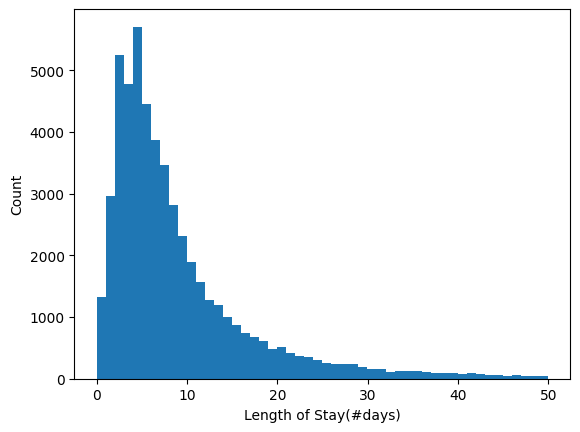

In [403]:
los_days = length_of_stay_df['length_of_stay'].tolist()
plt.hist([i for i in los_days if i<50], bins=50)
plt.ylabel('Count')
plt.xlabel('Length of Stay(#days)')

In [454]:
length_of_stay_df['ETHNICITY'] = length_of_stay_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN')
length_of_stay_df['ETHNICITY'] = length_of_stay_df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE')
length_of_stay_df['ETHNICITY'] = length_of_stay_df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO')
length_of_stay_df['ETHNICITY'] = length_of_stay_df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN')
length_of_stay_df['ETHNICITY'] = length_of_stay_df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN')
length_of_stay_df.loc[~length_of_stay_df['ETHNICITY'].isin(length_of_stay_df['ETHNICITY'].value_counts().nlargest(5).index.tolist()), 'ETHNICITY'] = 'OTHER/UNKNOWN'

In [455]:
length_of_stay_df.loc[~length_of_stay_df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE']), 'RELIGION'] = 'RELIGIOUS'

In [456]:
length_of_stay_df['MARITAL_STATUS'] = length_of_stay_df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [458]:
diagnosis_df = pd.read_csv(f'{mimic3_data_path}/DIAGNOSES_ICD.csv', compression='gzip')

In [459]:
diagnosis_df['recode'] = diagnosis_df['ICD9_CODE']
diagnosis_df['recode'] = diagnosis_df['recode'][~diagnosis_df['recode'].str.contains("[a-zA-Z]").fillna(False)]
diagnosis_df['recode'] = diagnosis_df['recode'].fillna(value='999')

diagnosis_df['recode'] = diagnosis_df['recode'].str.slice(start=0, stop=3, step=1)
diagnosis_df['recode'] = diagnosis_df['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diagnosis_df['recode'] = np.where(diagnosis_df['recode'].between(cat_range[0],cat_range[1]), 
            num, diagnosis_df['recode'])
    
# Convert integer to category name using diag_dict
diagnosis_df['recode'] = diagnosis_df['recode']
diagnosis_df['cat'] = diagnosis_df['recode'].replace(diag_dict)



/tmp/ipykernel_2551392/3577550821.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diagnosis_df['recode'] = diagnosis_df['recode'][~diagnosis_df['recode'].str.contains("[a-zA-Z]").fillna(False)]


In [460]:
hadm_list = diagnosis_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [410]:
diag_cols = list(set([i for j in hadm_list['cat'].tolist() for i in j]))

In [461]:
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [462]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [463]:
# Merge with main admissions df
length_of_stay_df = length_of_stay_df.merge(hadm_item, how='inner', on='HADM_ID')
length_of_stay_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,4,1,0,0,0,1,0,0,0,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,0,0,0,0,1,0,0,0,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,3,0,0,0,1,1,0,1,0,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0,0,0,0,0,0,0,0,0,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0,0,0,0,0,0,0,0,0,0


In [465]:
patients_df = pd.read_csv(f'{mimic3_data_path}/PATIENTS.csv', compression='gzip')

In [466]:
patients_df['DOB'] = pd.to_datetime(patients_df['DOB'])
patients_df = patients_df[['SUBJECT_ID', 'DOB', 'GENDER']]
patients_df.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [467]:
length_of_stay_df = length_of_stay_df.merge(patients_df, how='inner', on='SUBJECT_ID')

In [469]:
df_age_min = length_of_stay_df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']

In [470]:
length_of_stay_df = length_of_stay_df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [472]:
length_of_stay_df['DOB'] = pd.to_datetime(length_of_stay_df['DOB']).dt.date
length_of_stay_df['ADMIT_MIN'] = pd.to_datetime(length_of_stay_df['ADMIT_MIN']).dt.date

length_of_stay_df['age'] = length_of_stay_df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days//365, axis=1)
length_of_stay_df['age'] = np.where(length_of_stay_df['age'] < 0, 90, length_of_stay_df['age'])

In [474]:
length_of_stay_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,0,0,0,0,0,2138-07-17,M,2138-07-17,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,0,0,0,0,0,1,2025-04-11,M,2101-10-20,76
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,0,0,0,0,0,0,2143-05-12,F,2191-03-16,47
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,0,0,0,0,0,2103-02-02,M,2103-02-02,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,0,0,0,0,0,2109-06-21,F,2175-05-30,65


In [475]:
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    length_of_stay_df['age'] = np.where(length_of_stay_df['age'].between(cat_range[0],cat_range[1]), 
            num, length_of_stay_df['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior', 300: 'senior'}
length_of_stay_df['age'] = length_of_stay_df['age'].replace(age_dict)
length_of_stay_df.age.value_counts()

age
senior          29275
middle_adult    11752
newborn          8042
young_adult      4035
Name: count, dtype: int64

In [476]:
length_of_stay_df['GENDER'] = length_of_stay_df['GENDER'].replace({'M':0, 'F':1})

/tmp/ipykernel_2551392/1432823254.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  length_of_stay_df['GENDER'] = length_of_stay_df['GENDER'].replace({'M':0, 'F':1})


In [478]:
icu_df = pd.read_csv(f'{mimic3_data_path}/ICUSTAYS.csv', compression='gzip')

In [479]:
icu_df['FIRST_CAREUNIT'] = icu_df['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU', 'SICU': 'ICU', 'TSICU': 'ICU'})

In [480]:
icu_df['cat'] = icu_df['FIRST_CAREUNIT']
icu_list = icu_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [481]:
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [486]:
length_of_stay_df = length_of_stay_df.merge(icu_item, how='left', on='HADM_ID')

# Replace NaNs with 0
length_of_stay_df['ICU'] = length_of_stay_df['ICU'].fillna(value=0)
length_of_stay_df['NICU'] = length_of_stay_df['NICU'].fillna(value=0)

In [487]:
length_of_stay_df.isna().sum()

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53104
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                22512
RELIGION                    0
MARITAL_STATUS              0
ETHNICITY                   0
EDREGTIME               26321
EDOUTTIME               26321
DIAGNOSIS                  24
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
length_of_stay              0
blood                       0
circulatory                 0
congenital                  0
digestive                   0
endocrine                   0
genitourinary               0
infectious                  0
injury                      0
mental                      0
misc                        0
muscular                    0
neoplasms                   0
nervous                     0
pregnancy 

In [488]:
length_of_stay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53104 entries, 0 to 53103
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                53104 non-null  int64         
 1   SUBJECT_ID            53104 non-null  int64         
 2   HADM_ID               53104 non-null  int64         
 3   ADMITTIME             53104 non-null  datetime64[ns]
 4   DISCHTIME             53104 non-null  datetime64[ns]
 5   DEATHTIME             0 non-null      object        
 6   ADMISSION_TYPE        53104 non-null  object        
 7   ADMISSION_LOCATION    53104 non-null  object        
 8   DISCHARGE_LOCATION    53104 non-null  object        
 9   INSURANCE             53104 non-null  object        
 10  LANGUAGE              30592 non-null  object        
 11  RELIGION              53104 non-null  object        
 12  MARITAL_STATUS        53104 non-null  object        
 13  ETHNICITY       

In [489]:
length_of_stay_df = length_of_stay_df.merge(sdoh_merged_df, how='inner', on='HADM_ID')

In [490]:
length_of_stay_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,skin,DOB,GENDER,ADMIT_MIN,age,ICU,NICU,sdoh_community-present,sdoh_economics,sdoh_tobacco
0,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,1,2025-04-11,0,2101-10-20,senior,1.0,0.0,1,1,1
1,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,0,2143-05-12,1,2191-03-16,middle_adult,1.0,0.0,1,0,1
2,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,2109-06-21,1,2175-05-30,senior,1.0,0.0,1,0,1
3,12,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,...,0,2127-02-27,1,2167-01-08,middle_adult,1.0,0.0,0,0,0
4,14,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,0,2087-07-14,1,2134-12-27,middle_adult,1.0,0.0,1,0,0


In [491]:
length_of_stay_df.drop(columns=['ROW_ID', 'DISCHTIME', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'SUBJECT_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS',  'DEATHTIME'], inplace=True)

length_of_stay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39282 entries, 0 to 39281
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   HADM_ID                 39282 non-null  int64  
 1   ADMISSION_TYPE          39282 non-null  object 
 2   INSURANCE               39282 non-null  object 
 3   RELIGION                39282 non-null  object 
 4   MARITAL_STATUS          39282 non-null  object 
 5   ETHNICITY               39282 non-null  object 
 6   length_of_stay          39282 non-null  float64
 7   blood                   39282 non-null  int64  
 8   circulatory             39282 non-null  int64  
 9   congenital              39282 non-null  int64  
 10  digestive               39282 non-null  int64  
 11  endocrine               39282 non-null  int64  
 12  genitourinary           39282 non-null  int64  
 13  infectious              39282 non-null  int64  
 14  injury                  39282 non-null

In [492]:
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
length_of_stay_df = pd.get_dummies(length_of_stay_df, prefix=prefix_cols, columns=dummy_cols)
length_of_stay_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39282 entries, 0 to 39281
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   HADM_ID                     39282 non-null  int64  
 1   length_of_stay              39282 non-null  float64
 2   blood                       39282 non-null  int64  
 3   circulatory                 39282 non-null  int64  
 4   congenital                  39282 non-null  int64  
 5   digestive                   39282 non-null  int64  
 6   endocrine                   39282 non-null  int64  
 7   genitourinary               39282 non-null  int64  
 8   infectious                  39282 non-null  int64  
 9   injury                      39282 non-null  int64  
 10  mental                      39282 non-null  int64  
 11  misc                        39282 non-null  int64  
 12  muscular                    39282 non-null  int64  
 13  neoplasms                   392

In [493]:
length_of_stay_df.replace({True: 1, False: 0}, inplace=True)

/tmp/ipykernel_2551392/1606798456.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  length_of_stay_df.replace({True: 1, False: 0}, inplace=True)


In [494]:
length_of_stay_df.to_csv(f'/home/av38898/projects/sdoh/data/length_of_stay_features.csv', index=False)

# Run Models

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

/tmp/ipykernel_3232101/1882817934.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
length_of_stay_df = pd.read_csv(f'/home/av38898/projects/sdoh/data/length_of_stay_features.csv')

In [3]:
input_feature_columns = ['blood', 'circulatory', 'congenital',
       'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',
       'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy',
       'prenatal', 'respiratory', 'skin', 'GENDER', 'ICU', 'NICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Government',
       'INS_Medicaid', 'INS_Medicare', 'INS_Private', 'INS_Self Pay',
       'REL_NOT SPECIFIED', 'REL_RELIGIOUS', 'REL_UNOBTAINABLE', 'ETH_ASIAN',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'AGE_middle_adult', 'AGE_newborn',
       'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED', 'MAR_LIFE PARTNER',
       'MAR_MARRIED', 'MAR_SEPARATED', 'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)',
       'MAR_WIDOWED']

input_feature_columns_sdoh = input_feature_columns+['sdoh_community-present', 'sdoh_economics', 'sdoh_tobacco']

only_sdoh = ['sdoh_community-present', 'sdoh_economics', 'sdoh_tobacco']

In [4]:
X = length_of_stay_df[input_feature_columns_sdoh]
Y = length_of_stay_df[['length_of_stay']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 31425 samples.
Testing set has 7857 samples.


In [6]:
X_train_sdoh, X_test_sdoh = deepcopy(X_train), deepcopy(X_test)
X_train_only_sdoh, X_test_only_sdoh = X_train[only_sdoh], X_test[only_sdoh]
X_train, X_test = X_train[input_feature_columns], X_test[input_feature_columns]

### Run without SDoH features


In [7]:
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor done.


In [8]:
results

{'SGDRegressor': 0.22700124074776273,
 'GradientBoostingRegressor': 0.25506221761674186,
 'LinearRegression': 0.23126648272938755,
 'KNeighborsRegressor': 0.1366167786559228,
 'RandomForestRegressor': 0.22772251304672286}

### Run with SDoH features

In [9]:
models_sdoh = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results_sdoh = {}

for model in models_sdoh:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train_sdoh, y_train)
    
    # Make predictions with model
    y_test_preds_sdoh = reg_model.predict(X_test_sdoh)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results_sdoh[name] = r2_score(y_test, y_test_preds_sdoh)
    print('{} done.'.format(name))

/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor done.


In [10]:
results_sdoh

{'SGDRegressor': 0.22976802021689424,
 'GradientBoostingRegressor': 0.2510608455719803,
 'LinearRegression': 0.23400785243742306,
 'KNeighborsRegressor': 0.1433468663238131,
 'RandomForestRegressor': 0.2273243077904723}

In [11]:
models_only_sdoh = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results_only_sdoh = {}

for model in models_only_sdoh:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train_only_sdoh, y_train)
    
    # Make predictions with model
    y_test_preds_only_sdoh = reg_model.predict(X_test_only_sdoh)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results_only_sdoh[name] = r2_score(y_test, y_test_preds_only_sdoh)
    print('{} done.'.format(name))

/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor done.


In [12]:
results_only_sdoh

{'SGDRegressor': -0.00010222217269295619,
 'GradientBoostingRegressor': -0.00027436803546265764,
 'LinearRegression': 7.018138981074173e-08,
 'KNeighborsRegressor': -0.170476778615281,
 'RandomForestRegressor': -0.00032238751383806274}

### Run models with GridSearch optimized params with and without SDoH

In [561]:
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages

0.24156912361771338
GradientBoostingRegressor(max_depth=4, n_estimators=200)


In [562]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized)) 

Optimized R2 score is: 0.279065


In [563]:
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train_sdoh, y_train)
reg_model_optimized_sdoh = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/sdoh/lib/python3.9/site-packages

0.24251269017502067
GradientBoostingRegressor(n_estimators=300)


In [568]:
y_test_preds_sdoh = reg_model_optimized_sdoh.predict(X_test_sdoh)
r2_optimized_sdoh = r2_score(y_test, y_test_preds_sdoh)
print("Optimized R2 score is: {:2f}".format(r2_optimized_sdoh)) 

Optimized R2 score is: 0.267918


In [13]:
tuned_parameters = [{'n_estimators': [100, 200, 300],
                     'max_depth' : [2, 3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train_only_sdoh, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/skl

-0.0002785398856094856
GradientBoostingRegressor(max_depth=2)


In [14]:
y_test_preds = reg_model_optimized.predict(X_test_only_sdoh)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized)) 

Optimized R2 score is: -0.000201


### Convert LOS to binary Label

In [2]:
length_of_stay_df = pd.read_csv(f'/home/av38898/projects/sdoh/data/length_of_stay_features.csv')


In [3]:
length_of_stay_df['LOS_label'] = 0

In [6]:
length_of_stay_df['LOS_label'][length_of_stay_df['length_of_stay']>=7] = 1

/tmp/ipykernel_3232101/2541784528.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  length_of_stay_df['LOS_label'][length_of_stay_df['length_of_stay']>=7] = 1
/tmp/ipykernel_3232101/2541784528.py:1: SettingWithCopyWarning: 
A value is tryi

In [8]:
length_of_stay_df.to_csv(f'/home/av38898/projects/sdoh/data/length_of_stay_features.csv', index=False)

### Run models to predict LOS label 

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

In [2]:
length_of_stay_df = pd.read_csv(f'/home/av38898/projects/sdoh/data/length_of_stay_features.csv')

In [3]:
input_feature_columns = ['blood', 'circulatory', 'congenital',
       'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury',
       'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy',
       'prenatal', 'respiratory', 'skin', 'GENDER', 'ICU', 'NICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Government',
       'INS_Medicaid', 'INS_Medicare', 'INS_Private', 'INS_Self Pay',
       'REL_NOT SPECIFIED', 'REL_RELIGIOUS', 'REL_UNOBTAINABLE', 'ETH_ASIAN',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'AGE_middle_adult', 'AGE_newborn',
       'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED', 'MAR_LIFE PARTNER',
       'MAR_MARRIED', 'MAR_SEPARATED', 'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)',
       'MAR_WIDOWED']

input_feature_columns_sdoh = input_feature_columns+['sdoh_community-present', 'sdoh_economics', 'sdoh_tobacco']

only_sdoh = ['sdoh_community-present', 'sdoh_economics', 'sdoh_tobacco']

In [4]:
X = length_of_stay_df[input_feature_columns_sdoh]
Y = length_of_stay_df[['LOS_label']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 31425 samples.
Testing set has 7857 samples.


In [6]:
import pickle

with open('data/X_train_LOS_label.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('data/y_train_LOS_label.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('data/X_test_LOS_label.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('data/y_test_LOS_label.pkl', 'wb') as f:
    pickle.dump(y_test, f)


In [10]:
import pickle

with open('data/LOS_label/X_train_LOS_label.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('data/LOS_label/y_train_LOS_label.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('data/LOS_label/X_test_LOS_label.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('data/LOS_label/y_test_LOS_label.pkl', 'rb') as f:
    y_test = pickle.load(f)


In [11]:
X_train_sdoh, X_test_sdoh = deepcopy(X_train), deepcopy(X_test)
X_train_only_sdoh, X_test_only_sdoh = X_train[only_sdoh], X_test[only_sdoh]
X_train, X_test = X_train[input_feature_columns], X_test[input_feature_columns]

In [13]:
models = [LogisticRegression(random_state = 0),
          AdaBoostClassifier(random_state = 0), 
          RandomForestClassifier(random_state = 0), 
          KNeighborsClassifier(n_neighbors=10),
          SVC(random_state = 0, probability=True),
          DecisionTreeClassifier(random_state = 0)]

results = {}

for model in models:
    name = str(model).split("(")[0]
    print(f'Running: {model}')
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds_proba = reg_model.predict_proba(X_test)[:, 1]
    y_test_preds = reg_model.predict(X_test)

    results[name] = {
        'f1': f1_score(y_test, y_test_preds),
        'auc': roc_auc_score(y_test, y_test_preds_proba)
    }
    print('{} done.'.format(name))

Running: LogisticRegression(random_state=0)


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression done.
Running: AdaBoostClassifier(random_state=0)


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier done.
Running: RandomForestClassifier(random_state=0)


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier done.
Running: KNeighborsClassifier(n_neighbors=10)


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier done.
Running: SVC(probability=True, random_state=0)


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC done.
Running: DecisionTreeClassifier(random_state=0)
DecisionTreeClassifier done.


In [14]:
results

{'LogisticRegression': {'f1': 0.6445548543037465, 'auc': 0.7293527408396006},
 'AdaBoostClassifier': {'f1': 0.648815931108719, 'auc': 0.729315383986332},
 'RandomForestClassifier': {'f1': 0.6583128794729363,
  'auc': 0.7238636485871592},
 'KNeighborsClassifier': {'f1': 0.5620572836464429, 'auc': 0.696779217174018},
 'SVC': {'f1': 0.6645299145299145, 'auc': 0.7455416069810206},
 'DecisionTreeClassifier': {'f1': 0.5854094800051105,
  'auc': 0.586994942147745}}

In [15]:
models_sdoh = [LogisticRegression(random_state = 0),
               AdaBoostClassifier(random_state = 0), 
          RandomForestClassifier(random_state = 0), 
          KNeighborsClassifier(n_neighbors=10),
          SVC(random_state = 0, probability=True),
          DecisionTreeClassifier(random_state = 0)]

results_sdoh  = {}

for model in models_sdoh:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train_sdoh, y_train)
    
    # Make predictions with model
    y_test_preds_proba = reg_model.predict_proba(X_test_sdoh)[:, 1]
    y_test_preds = reg_model.predict(X_test_sdoh)

    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results_sdoh[name] = {
        'f1': f1_score(y_test, y_test_preds),
        'auc': roc_auc_score(y_test, y_test_preds_proba)
    }
    print('{} done.'.format(name))

/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC done.
DecisionTreeClassifier done.


In [16]:
results_sdoh

{'LogisticRegression': {'f1': 0.6476370001346439, 'auc': 0.7312581347544964},
 'AdaBoostClassifier': {'f1': 0.6497776579975745, 'auc': 0.7307568142075532},
 'RandomForestClassifier': {'f1': 0.6620957309184994,
  'auc': 0.7303770249326054},
 'KNeighborsClassifier': {'f1': 0.555401019935095, 'auc': 0.6977346195063556},
 'SVC': {'f1': 0.6697911087305838, 'auc': 0.7475069403395824},
 'DecisionTreeClassifier': {'f1': 0.5921366662479588,
  'auc': 0.5866705887582634}}

In [17]:
models_sdoh_only = [LogisticRegression(random_state = 0),
                    AdaBoostClassifier(random_state = 0), 
          RandomForestClassifier(random_state = 0), 
          KNeighborsClassifier(n_neighbors=10),
          SVC(random_state = 0, probability=True),
          DecisionTreeClassifier(random_state = 0)]

results_sdoh_only = {}

for model in models_sdoh_only:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train_only_sdoh, y_train)
    
    # Make predictions with model
    y_test_preds_proba = reg_model.predict_proba(X_test_only_sdoh)[:, 1]
    y_test_preds = reg_model.predict(X_test_only_sdoh)

    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results_sdoh_only[name] = {
        'f1': f1_score(y_test, y_test_preds),
        'auc': roc_auc_score(y_test, y_test_preds_proba)
    }
    print('{} done.'.format(name))

LogisticRegression done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier done.


/home/av38898/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC done.
DecisionTreeClassifier done.


In [18]:
results_sdoh_only

{'LogisticRegression': {'f1': 0.5578446909667195, 'auc': 0.5067669687917025},
 'AdaBoostClassifier': {'f1': 0.5578446909667195, 'auc': 0.5067669687917025},
 'RandomForestClassifier': {'f1': 0.5087564570996598,
  'auc': 0.5127916280732249},
 'KNeighborsClassifier': {'f1': 0.2391220639199076, 'auc': 0.4935498678675464},
 'SVC': {'f1': 0.5087564570996598, 'auc': 0.5016180085822916},
 'DecisionTreeClassifier': {'f1': 0.5087564570996598,
  'auc': 0.5108694187144033}}